In [1]:
%matplotlib inline

In [10]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import theano
from scipy.signal import savgol_filter

import celerite
from celerite import terms
from tqdm import tqdm, tqdm_notebook

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.3
1.0.4
3.6


In [4]:
target = 'AU Mic'
lcf = lightkurve.search_lightcurvefile(target).download(quality_bitmask='hard',)
lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()
lc_hdr = lcf.header(ext=1)

texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
flux = (lc.flux - 1.0) * 1e3
time = lc.time
flux_err = lc.flux_err
m = np.isfinite(time) & np.isfinite(flux)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(20):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma*1.5
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

x = time
y = flux
yerr = flux_err

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [5]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]

In [6]:
def build_model(mask=None, start=None):
    guess_p_period = 16.93, 30.537
    guess_p_t0 = -8.84, 2.9955
    guess_p_depth = 0.04, 0.02
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.4, 0.2]))
        R_star = 0.75, 0.03
        Rho_star = 1.7
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=0.4)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.2, shape=2, 
                         testval=np.log(guess_p_period))
        t0 = pm.Normal("t0", mu=guess_p_t0, sd=0.1, shape=2, testval=guess_p_t0)
        
        logror = pm.Bound(pm.Normal, lower=np.log(0.0), upper=np.log(0.3))("logror", 
                                                                            mu=np.log(guess_p_depth),
                                                                            sd=2, shape=2)
        ror = pm.Deterministic("ror", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=2, testval=[0.2, 0.3])
        b = pm.Deterministic("b", b_param * (1 + ror))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.8)("ecc", alpha=0.867, beta=3.03, testval=0.1,
                                                     shape=2)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.1,0.05], shape=2)
        omega = xo.distributions.Angle("omega", shape=2)
        
#         ecc= [0., 0.]
#         omega = [0, 0]

        
#         pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
#         pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        
        # this prior seems to be needed
        pm.Potential("p_period_prior", tt.switch((p_period < 16.96) | (p_period > 20), 0, -np.inf))
        
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param, logP, t0])
    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidime

In [7]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

In [8]:
model, map_soln = build_model(mask, map_soln0)

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -8,005.4, ||grad|| = 922.17: 100%|██████████| 8/8 [00:00<00:00, 57.84it/s]   
logp = -7,762.5, ||grad|| = 0.00087772: 100%|██████████| 22/22 [00:00<00:00, 47.33it/s]  
logp = -7,753.1, ||grad|| = 0.06835: 100%|██████████| 19/19 [00:00<00:00, 45.12it/s]  
logp = -7,753.1, ||grad|| = 0.59763: 100%|██████████| 21/21 [00:00<00:00, 60.11it/s]  
logp = -7,753.1, ||grad|| = 0.22738: 100%|██████████| 4/4 [00:00<00:00, 56.40it/s]
logp = -7,753, ||grad|| = 284.95: 100%|██████████| 16/16 [00:00<00:00, 63.30it/s]  


In [9]:
with model:
    trace = pm.load_trace('.pymc_2.trace')

In [ ]:
# def plot_sample(sample, ax):
#     orbit = xo.orbits.KeplerianOrbit(
#             r_star=sample['r_star'],
#             period=sample['p_period'], t0=sample['t0'], b=sample['b'],
#             rho_star=sample['rho_star'], ecc=sample['ecc'], omega=sample['omega'])
#     with model:
#         mu, var = xo.eval_in_model(gp.predict(stime, return_var=True), sample)
#         sd = np.sqrt(var)
#         light_curves = xo.eval_in_model(xo.StarryLightCurve(sample['u_star']).get_light_curve(
#                 orbit=orbit, r=sample['r_pl'], t=stime, texp=texp)*1e3)
#     art = ax.fill_between(stime, mu+sd, mu-sd, color="C2", alpha=0.3,
#                        zorder=1000)
#     art.set_edgecolor("none")
#     ax.plot(stime, light_curves[:,0], color="C1", alpha=0.3,
#                        zorder=1000)


#     return ax
    
# i = 0
# fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 7])
# stime = np.arange(x[mask][13800], x[mask][14400], np.median(np.diff(x[mask])))
# ax2.plot(x[mask],y[mask] - sample['mean'], ".k", label="data",
#          alpha=0.3, zorder=-1000, mec="none")
# ax1.plot(x[mask],y[mask] - sample['mean'], ".k", label="data",
#          alpha=0.3, zorder=-1000, mec="none")
# while True:
#     sample = [q for q in xo.get_samples_from_trace(trace, size=1)][0]
#     if sample['p_period'][0] > 16.96:
#         continue
#     else:
#         i+= 1
#         ax1 = plot_sample(sample, ax1)
#         ax2.set_ylim(-30, 10)
#         ax2.set_xlim(7.5, 8.5)
#         ax2 = plot_sample(sample, ax2)
#         ax2.set_ylim(-30, 10)
#         ax2.set_xlim(7.5, 8.5)
#     if i >= 15:
#         break

        

In [11]:
stime = np.arange(x[mask][13800], x[mask][14400], np.median(np.diff(x[mask])))
N_pred = 50
pred_mu = np.empty((N_pred, len(stime)))
pred_var = np.empty((N_pred, len(stime)))

with model:
    pred = gp.predict(true_t, return_var=True)



In [12]:
# fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 6])
# ax1.plot(x[mask],y[mask]- sample['mean'])
# # plt.plot(stime,mu )
# ax1.fill_between(stime, mu+sd, mu-sd, color="C1", alpha=0.5, zorder=100)
# ax1.set_xlim(-1 - 8.8+17,1 - 8.8+17)
# ax1.set_ylim(-20, 25)

In [13]:
x[mask][14300]

8.356872905677164

In [14]:
# with model:
#     mu, var = xo.eval_in_model(gp.predict(stime, return_var=True), sample)

In [15]:
# orbit = xo.orbits.KeplerianOrbit(
#             r_star=sample['r_star'],
#             period=sample['p_period'], t0=sample['t0'], b=sample['b'],
#             rho_star=sample['rho_star'], ecc=sample['ecc'], omega=sample['omega'])

In [16]:
# with model:
#     light_curves = xo.eval_in_model(xo.StarryLightCurve(sample['u_star']).get_light_curve(
#             orbit=orbit, r=sample['r_pl'], t=stime, texp=texp)*1e3)

In [17]:
# fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 6])





# ax2.plot(x[mask],y[mask]- sample['mean'])
# ax2.fill_between(stime, mu+sd, mu-sd, color="C1", alpha=0.5, zorder=100)
# ax2.set_xlim(-1 - 8.8+17,1 - 8.8+17)
# ax2.plot(stime, light_curves[:,0], color='C1', label = 'transit model')
# ax2.set_ylim(-20, 25)

In [18]:
# i = 1000
# logS = trace.get_values('logS', burn=1000, chains=[2])[i]
# logw = trace.get_values('logw', burn=1000, chains=[2])[i]
# logamp = trace.get_values('logamp', burn=1000, chains=[2])[i]
# period = trace.get_values('period', burn=1000, chains=[2])[i]
# logQ0 = trace.get_values('logQ0', burn=1000, chains=[2])[i]
# logdeltaQ = trace.get_values('logdeltaQ', burn=1000, chains=[2])[i]
# mix = trace.get_values('mix', burn=1000, chains=[2])[i]
# logs2 = trace.get_values('logs2', burn=1000, chains=[2])[i]
# mean = trace.get_values('mean', burn=1000, chains=[2])[i]
# light_curve = trace.get_values('light_curve', burn=1000, chains=[2])[i]

In [19]:
# term1 = terms.SHOTerm(log_S0=logS, log_omega0=logw, log_Q=np.log(1/np.sqrt(2)))
# term2 = terms.RotationTerm(
#     log_amp=logamp,
#     period=period,
#     log_Q0=logQ0,
#     log_deltaQ=logdeltaQ,
#     mix=mix
# )

In [20]:
# # Generate 50 realizations of the prediction sampling randomly from the chain
# N_pred = 50
# pred_mu = np.empty((N_pred, len(true_t)))
# pred_var = np.empty((N_pred, len(true_t)))
# with model:
#     pred = gp.predict(true_t, return_var=True)
#     for i, sample in enumerate(xo.get_samples_from_trace(trace, size=N_pred)):
#         pred_mu[i], pred_var[i] = xo.eval_in_model(pred, sample)

# # Plot the predictions
# for i in range(len(pred_mu)):
#     mu = pred_mu[i]
#     sd = np.sqrt(pred_var[i])
#     label = None if i else "prediction"
#     art = plt.fill_between(true_t, mu+sd, mu-sd, color="C1", alpha=0.1)
#     art.set_edgecolor("none")
#     plt.plot(true_t, mu, color="C1", label=label, alpha=0.1)

# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
# plt.legend(fontsize=12)
# plt.xlabel("t")
# plt.ylabel("y")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5);



In [21]:
# sample = [x for x in xo.get_samples_from_trace(trace, size=1)

# with model:
#     mu, var = xo.eval_in_model(gp.predict(true_t, return_var=True), sample)

In [22]:
# for i, sample in enumerate(xo.get_samples_from_trace(trace, size=1)):
#     pred_mu, pred_var = xo.eval_in_model(pred, sample)

In [23]:
# for i, sample in enumerate(xo.get_samples_from_trace(trace, size=1)):
    

In [13]:
pm.summary(trace, varnames= ['b', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star', 'mix', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS',
                             'logs2', 'mean', 'r_ple', 'p_period', 'ror'], alpha=0.317)


,mean,sd,mc_error,hpd_15.85,hpd_84.15,n_eff,Rhat
b__0,0.233138,0.155683,2.152425e-03,0.000368,0.306798,5446.001769,1.000359
b__1,0.505055,0.274896,4.697924e-03,0.211539,0.832341,3894.328862,1.000598
logror__0,-2.945834,0.038561,4.059933e-04,-2.980105,-2.903814,9918.379705,1.000079
logror__1,-4.318042,1.202439,3.997979e-02,-4.473528,-3.232582,855.320855,1.001180
t0__0,-8.854524,0.000498,5.209175e-06,-8.855017,-8.854034,10750.018600,0.999985
t0__1,2.985866,0.058657,1.206195e-03,2.949935,3.012588,2299.985846,1.000214
logP__0,2.829075,0.000046,5.898919e-07,2.829036,2.829122,6267.788415,1.000252
logP__1,3.419558,0.188470,2.312473e-03,3.212790,3.598702,6497.689947,1.000026
ecc__0,0.240605,0.160471,2.391300e-03,0.000140,0.306808,4663.304047,0.999881
ecc__1,0.211190,0.175174,2.241298e-03,0.000010,0.268582,6382.742371,1.000266


In [14]:
samples = pm.trace_to_dataframe(trace)
samples = samples.loc[samples.p_period__0 < 16.96]

In [15]:
samples.mean(), samples.std()

(mean            6.529822
 logs2          -2.261715
 logS           -5.697942
 logw            4.392854
 logamp          4.845878
 logperiod       1.581646
 logQ0           1.635157
 logdeltaQ      12.542065
 r_star          0.749711
 logrho_star     0.867433
 logP__0         2.829075
 logP__1         3.419558
 t0__0          -8.854524
 t0__1           2.985866
 period          4.863083
 mix             0.469125
 u_star__0       0.261789
 u_star__1       0.048064
 rho_star        2.548303
 logror__0      -2.945834
 logror__1      -4.318042
 ror__0          0.052597
 ror__1          0.020323
 b_param__0      0.221451
 b_param__1      0.494687
 b__0            0.233138
 b__1            0.505055
 ecc__0          0.240605
 ecc__1          0.211190
 omega__0        1.099546
                  ...    
 pred__17431    28.434552
 pred__17432    28.466457
 pred__17433    28.495212
 pred__17434    28.521570
 pred__17435    28.546593
 pred__17436    28.573256
 pred__17437    28.600862
 pred__17438

In [16]:
samples.loc[:, 'ecc__0'].std()

0.16047815977606122

(array([840., 665., 626., 659., 720., 743., 726., 756., 753., 723., 644.,
        633., 569., 536., 454., 345., 334., 266., 226., 180., 114., 112.,
         94.,  67.,  41.,  42.,  50.,  31.,  31.,  20.]),
 array([2.65531269e-05, 2.66416941e-02, 5.32568351e-02, 7.98719760e-02,
        1.06487117e-01, 1.33102258e-01, 1.59717399e-01, 1.86332540e-01,
        2.12947681e-01, 2.39562822e-01, 2.66177963e-01, 2.92793104e-01,
        3.19408245e-01, 3.46023386e-01, 3.72638527e-01, 3.99253668e-01,
        4.25868809e-01, 4.52483950e-01, 4.79099091e-01, 5.05714232e-01,
        5.32329372e-01, 5.58944513e-01, 5.85559654e-01, 6.12174795e-01,
        6.38789936e-01, 6.65405077e-01, 6.92020218e-01, 7.18635359e-01,
        7.45250500e-01, 7.71865641e-01, 7.98480782e-01]),
 <a list of 30 Patch objects>)

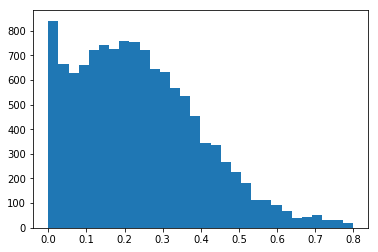

In [17]:
plt.hist(samples.loc[:, 'ecc__0'], bins=30)

In [18]:
stime = np.arange(x[mask][0], x[mask][-1], np.median(np.diff(x[mask])))
N_pred = 1000
pred_transit = np.empty((N_pred, len(stime)))
i = 0

pbar = tqdm(total=N_pred)
while i < 1000:
    sample = [q for q in xo.get_samples_from_trace(trace, size=1)][0]
    if sample['p_period'][0] < 16.96:
        orbit = xo.orbits.KeplerianOrbit(
                r_star=sample['r_star'],
                period=sample['p_period'], t0=sample['t0'], b=sample['b'],
                rho_star=sample['rho_star'], ecc=sample['ecc'], omega=sample['omega'])
        with model:
            light_curve = xo.eval_in_model(xo.StarryLightCurve(sample['u_star']).get_light_curve(
                    orbit=orbit, r=sample['r_pl'], t=stime, texp=texp)*1e3)[:, 0]
        pred_transit[i] = light_curve
        pbar.update(1)
        i+=1
    else:
        continue
    



  0%|          | 0/150 [00:00<?, ?it/s]/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
  1%|          | 1/150 [00:12<30:23, 12.24s/it]/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 150/150 [46:41<00:00, 25.30s/it]

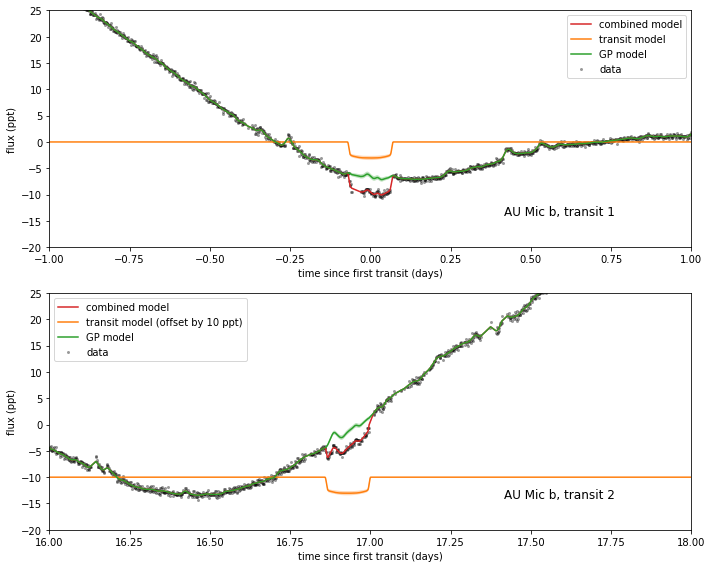

In [19]:
pmask = trace["p_period"][:, 0] < 16.96
pred = np.percentile(trace["light_curve"][pmask] + trace["mean"][pmask, None] +
                     trace["pred"][pmask], [5,50,95], axis=0)
# pred1 = np.percentile(trace["light_curve"][pmask], [5,50,95], axis=0)
pred1 = np.percentile(pred_transit, [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"][pmask] + trace["mean"][pmask, None], [5,50,95], axis=0)

fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[10, 8])
time = x[mask] - np.median(trace['t0'][pmask,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(stime - np.median(trace['t0'][pmask,0]),
         pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(stime - np.median(trace['t0'][pmask,0]),
                       pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(stime - np.median(trace['t0'][pmask,0]), pred1[1] -10,
         color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(stime - np.median(trace['t0'][pmask,0]),
                       pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP-v3.png', dpi=200)

In [20]:
samples = pm.trace_to_dataframe(trace)
samples = samples.loc[samples.p_period__0 < 16.96]

In [21]:
q = np.percentile(samples.loc[:, ['p_period__0', 'r_ple__0', 't0__0', 'ror__0', 'b__0', 'ecc__0']], [16,50,84], axis=0)

In [22]:
print(q[1])
print(q[2] - q[1])
print(q[1] - q[0])

[16.92981554  4.30559017 -8.85452052  0.05262756  0.2133248   0.22265257]
[0.00071185 0.2351542  0.00048521 0.00196549 0.19515155 0.17894884]
[0.00074792 0.23413238 0.00049159 0.00203274 0.14877527 0.15171414]


In [154]:
7.45934563e-04

0.000745934563

(array([   3.,   11.,   16.,   47.,  188.,  747., 1178.,  669.,  127.,
          14.]),
 array([2.82879834, 2.82884395, 2.82888955, 2.82893516, 2.82898076,
        2.82902637, 2.82907198, 2.82911758, 2.82916319, 2.82920879,
        2.8292544 ]),
 <a list of 10 Patch objects>)

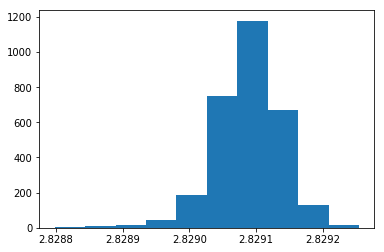

In [157]:
plt.hist(samples.logP__0)

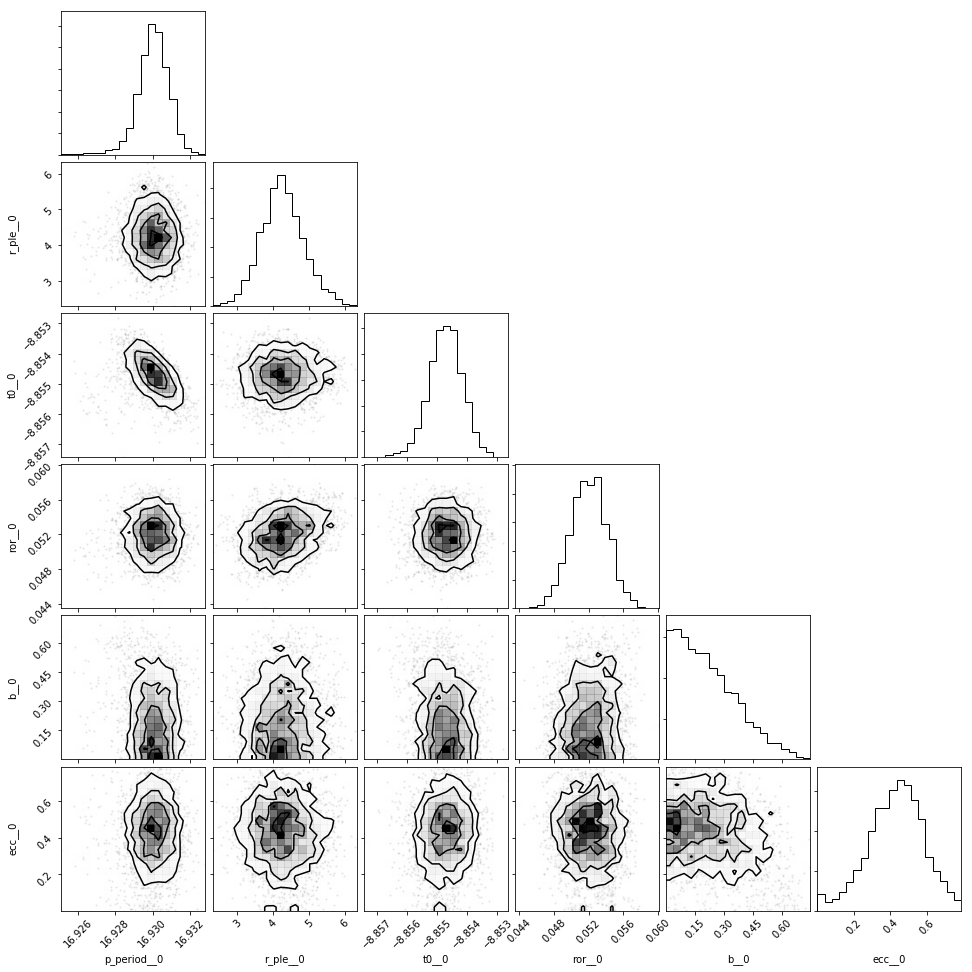

In [161]:
import corner
q = corner.corner(samples.loc[:, ['p_period__0', 'r_ple__0', 't0__0', 'ror__0', 'b__0', 'ecc__0']])

In [39]:
psamps = samples.loc[:, 'r_ple__1'].values

In [98]:
from scipy.optimize import curve_fit, minimize


[-1.13249468e+00  1.35398071e-01  2.64579845e+02  1.29437224e+00
  1.57755861e+00  2.01365020e+02] 
 [inf inf inf inf inf inf]


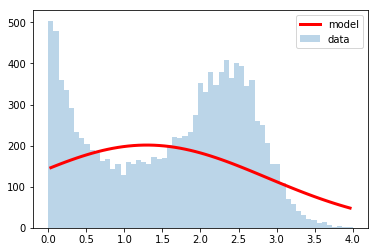

In [110]:
ytt,xtt,_= plt.hist(psamps,np.linspace(0,4,60),alpha=.3,label='data')
xtt=(xtt[1:]+xtt[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def nll(params, x, y):
    mu1,sigma1,A1,mu2,sigma2,A2 = params
    model = gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    return np.sum((ytt - model)**2)

expected=(0,0.3,700,2,0.3,600)
# params,cov=curve_fit(bimodal,xtt,ytt, p0=expected, maxfev=10000, )
sigma=np.sqrt(np.diag(cov))
plt.plot(xtt,bimodal(xtt,*params),color='red',lw=3,label='model')
plt.legend()
print(params,'\n',sigma)  

In [112]:
out = minimize(nll, x0=[0.1,1,500,2,1,300], args=(xtt,ytt))

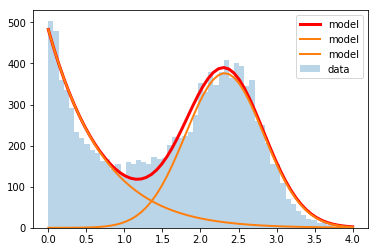

In [119]:
plt.plot(xtt,bimodal(xtt,*out['x']),color='red',lw=3,label='model')
plt.plot(xtt,gauss(xtt,*out['x'][0:3]),color='C1',lw=2,label='model')
plt.plot(xtt,gauss(xtt,*out['x'][3:7]),color='C1',lw=2,label='model')
ytt,xtt,_= plt.hist(psamps,np.linspace(0,4,60),alpha=.3,label='data')
plt.legend()

In [121]:
out['x'][3:]

array([  2.31782876,   0.51210045, 376.3630679 ])

In [126]:

np.percentile(samples.loc[samples.r_ple__1 > 1.4,
                          ['p_period__1', 'r_ple__1', 't0__1', 'ror__1', 'b__1', 'ecc__1']], [16,50,84], axis=0)

array([[2.50041898e+01, 1.80077631e+00, 2.96342665e+00, 2.21779972e-02,
        1.98992607e-01, 4.06144211e-02],
       [3.01644470e+01, 2.32393941e+00, 2.97762491e+00, 2.84600887e-02,
        5.37223891e-01, 1.63496145e-01],
       [3.67450103e+01, 2.79774058e+00, 2.99739606e+00, 3.40673190e-02,
        7.87043375e-01, 3.93007513e-01]])

In [18]:
stime = np.arange(x[mask][0], x[mask][-1], np.median(np.diff(x[mask])))
N_pred = 1000
pred_transit = np.empty((N_pred, len(stime), 2))
i = 0

pbar = tqdm_notebook(total=N_pred)
while i < 1000:
    sample = [q for q in xo.get_samples_from_trace(trace, size=1)][0]
    if sample['r_ple'][1] > 1.0:
        orbit = xo.orbits.KeplerianOrbit(
                r_star=sample['r_star'],
                period=sample['p_period'], t0=sample['t0'], b=sample['b'],
                rho_star=sample['rho_star'], ecc=sample['ecc'], omega=sample['omega'])
        with model:
            light_curve = xo.eval_in_model(xo.StarryLightCurve(sample['u_star']).get_light_curve(
                    orbit=orbit, r=sample['r_pl'], t=stime, texp=texp)*1e3)[:]
        pred_transit[i, :, :] = light_curve
        pbar.update(1)
        i+=1
    else:
        continue
    

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano

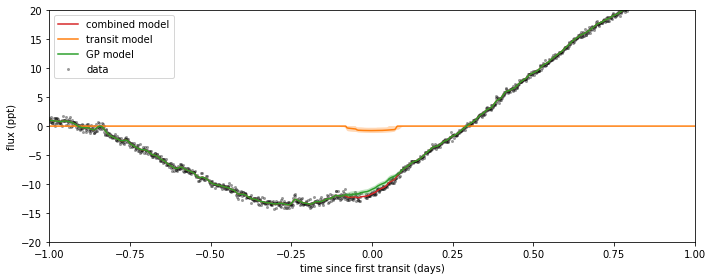

In [158]:
pmask = trace["r_ple"][:, 1] > 1.
pred = np.percentile(trace["light_curve"][pmask] + trace["mean"][pmask, None] +
                     trace["pred"][pmask], [15,50,85], axis=0)
# pred1 = np.percentile(trace["light_curve"][pmask], [15,50,85], axis=0)
pred1 = np.percentile(pred_transit[:,:,1], [15,50,85], axis=0)
pred2 = np.percentile(trace["pred"][pmask] + trace["mean"][pmask, None], [15,50,85], axis=0)

fig,  ax1 = plt.subplots(1,1, figsize=[10, 4])
time = x[mask] - np.median(trace['t0'][pmask,1])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

# ax1.plot(stime - np.median(trace['t0'][pmask,1]),
#          pred1[1], color='C1', label = 'transit model')
plt.plot(stime - np.median(trace['t0'][pmask,1]), pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(stime - np.median(trace['t0'][pmask,1]),
                       pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 20)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

# ax1.annotate('AU Mic c', (0.7, 0.1), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)



plt.tight_layout()
plt.savefig('transits-GP-planet-c.png', dpi=200)

(-20, 20)

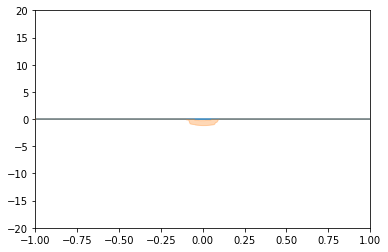

In [25]:
plt.plot(stime - np.median(trace['t0'][pmask,1]), pred_transit1[47])
plt.fill_between(stime - np.median(trace['t0'][pmask,1]),
                       pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
plt.xlim(-1,1)
plt.ylim(-20, 20)

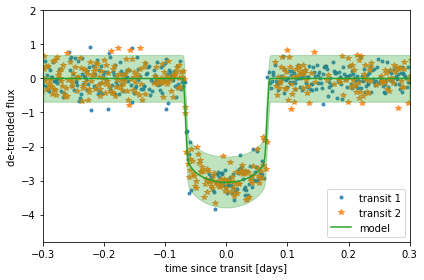

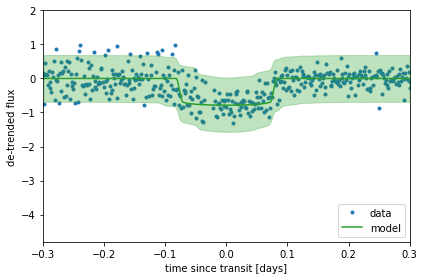

In [162]:
pmask = trace["r_ple"][:, 1] > 1.
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["pred"][pmask], axis=0)
    offset = np.median(trace["mean"][pmask, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["p_period"][pmask, n])
    t0 = np.median(trace["t0"][pmask, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
#     other = np.median(trace["light_curve"][:, :,], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    mid = int(np.shape(x[mask])[0] / 2)
    x_fold0 = (x[mask][:mid] - t0 + 0.5*p) % p - 0.5*p
    x_fold1 = (x[mask][mid:] - t0 + 0.5*p) % p - 0.5*p
    if n == 0:
        plt.plot(x_fold0, y[mask][:mid] - gp_mod[:mid] - offset, ".C0", label="transit 1", zorder=-1000, alpha=0.8)
        plt.plot(x_fold1, y[mask][mid:] - gp_mod[mid:] - offset, "*C1", label="transit 2", zorder=-1000, alpha=0.8)

#         art.set_edgecolor("none")
    
    elif n == 1:
        plt.plot(x_fold, y[mask] - gp_mod - offset, ".C0", label="data", zorder=-1000)
        plt.plot(stime - np.median(trace['t0'][pmask,1]), pred_transit[79,:,1],
          "C2", label = 'model')
#         art = plt.fill_between(stime - np.median(trace['t0'][pmask,1]),
#                        pred1[0], pred1[2], color="C1", alpha=0.3,
#                        zorder=1000)
#         art.set_edgecolor("none")

    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curve"][:, inds][pmask] - offset  + trace["mean"][pmask, None] 
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    if n == 0:
        plt.plot(x_fold[inds], pred[1], color="C2", label="model")
    art = plt.fill_between(x_fold[inds], pred[0],
                           pred[2], color="C2", alpha=0.3,
                           zorder=1000)    
    # Plot the folded model

    # Annotate the plot with the planet's period
#     txt = "period = {0:.4f} +/- {1:.4f} d".format(
#         np.mean(trace["p_period"][pmask, n]), np.std(trace["p_period"][pmask, n]))
#     plt.annotate(txt, (0, 0), xycoords="axes fraction",
#                  xytext=(5, 5), textcoords="offset points", 
#                  ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.ylim(-4.8,2)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
#     plt.title("AU Mic {0}".format(letter));
    plt.xlim(-0.3, 0.3)
    plt.tight_layout()
    plt.savefig('transit-plot-{}.png'.format(n+1), dpi=200)

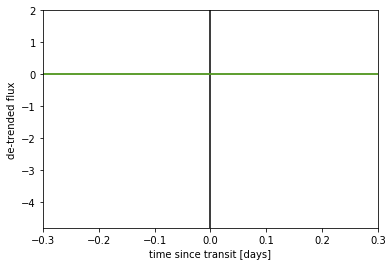

In [82]:
plt.plot(stime - np.median(trace['t0'][pmask,1]), pred_transit1[114], color='C1', label = 'transit model')
plt.plot(stime - np.median(trace['t0'][pmask,1]), pred_transit1[4], color='C2', label = 'transit model')
plt.ylim(-4.8,2)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
#     plt.title("AU Mic {0}".format(letter));
plt.xlim(-0.3, 0.3)
plt.vlines(0, -5,2)

MemoryError: 

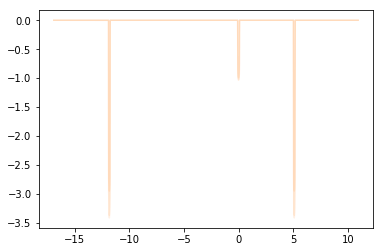

In [275]:
for i in np.random.choice(range(0,trace["light_curve"][pmask].shape[0]), size=50):
    plt.plot(time, trace["light_curve"][pmask][i], color='C1', alpha=0.1)

plt.ylim(-4.8,2)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
#     plt.title("AU Mic {0}".format(letter));
plt.xlim(-0.3, 0.3)
plt.vlines(0, -5,2)

In [276]:
trace["light_curve"][pmask][i]

MemoryError: 

In [17]:
 light_curve.shape

(20063, 2)

In [68]:
q = np.min(trace["light_curve"][:, inds][pmask], axis=0)

In [79]:
np.argmin(np.abs(np.median(q) - q))

114

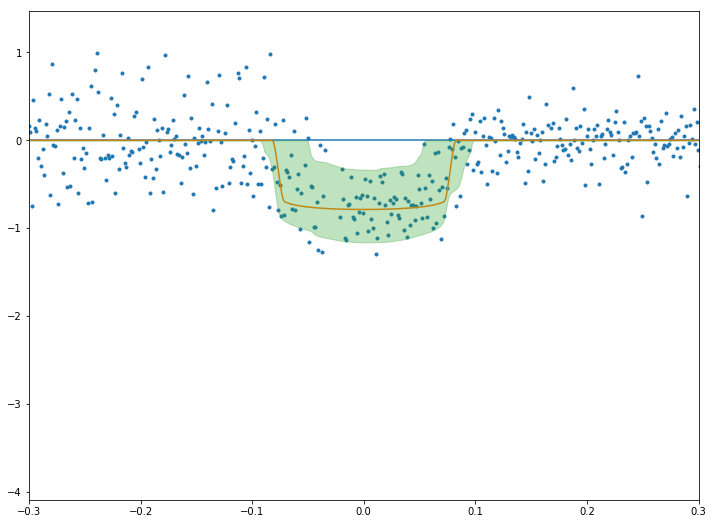

In [147]:
plt.figure(figsize=[12,9])
plt.plot(x_fold, y[mask] - gp_mod - offset, ".C0", label="data", zorder=-1000)
[plt.plot(stime - np.median(trace['t0'][pmask,1]), pred_transit[n],
          label = 'transit model') for n in range(79,80)]
plt.xlim(-0.3, 0.3)
plt.fill_between(x_fold[inds], pred[0],
                           pred[2], color="C2", alpha=0.3,
                           zorder=1000)    

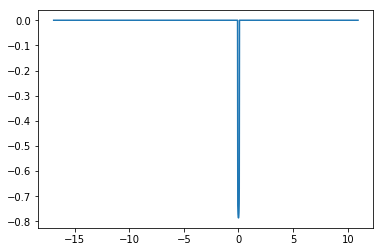

In [155]:
plt.plot(stime - np.median(trace['t0'][pmask,1]), pred_transit[79,:,1],
          label = 'transit model')

In [161]:
trace["light_curve"][:, inds][pmask] - offset  + trace["mean"][pmask, None] 

array([[-0.15747524, -0.15747524, -0.15747524, ..., -0.15747524,
        -0.15747524, -0.15747524],
       [-1.4942704 , -1.4942704 , -1.4942704 , ..., -1.4942704 ,
        -1.4942704 , -1.4942704 ],
       [-1.42601204, -1.42601204, -1.42601204, ..., -1.42601204,
        -1.42601204, -1.42601204],
       ...,
       [-0.45041471, -0.45041471, -0.45041471, ..., -0.45041471,
        -0.45041471, -0.45041471],
       [ 0.811249  ,  0.811249  ,  0.811249  , ...,  0.811249  ,
         0.811249  ,  0.811249  ],
       [-0.33055526, -0.33055526, -0.33055526, ..., -0.33055526,
        -0.33055526, -0.33055526]])

In [188]:
trace.__

AttributeError: 'MultiTrace' object has no attribute '__logp'